In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import os
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, GRU, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D, Bidirectional, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (Dense, Dropout, LSTM, GRU, SimpleRNN, 
                                    Conv1D, GlobalMaxPooling1D, Masking, 
                                    Reshape, TimeDistributed)
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Load the datasets
train_df = pd.read_csv('train (2).csv')
test_df = pd.read_csv('test (2).csv')
submission_file = pd.read_csv('submission_file.csv')

In [4]:
# Display basic information
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)
print("Submission file shape:", submission_file.shape)

# Display first few rows of train data
train_df.head()

Train dataset shape: (19826, 6)
Test dataset shape: (4957, 5)
Submission file shape: (4958, 2)


,count,hate_speech_count,offensive_language_count,neither_count,tweet,class
0,3,2,0,1,RT @FunSizedYogi: @TheBlackVoice well how else...,0
1,3,0,0,3,Funny thing is....it's not just the people doi...,2
2,3,0,3,0,"RT @winkSOSA: ""@AintShitSweet__: ""@Rakwon_OGOD...",1
3,3,0,3,0,@Jbrendaro30 @ZGabrail @ramsin1995 @GabeEli8 @...,1
4,6,0,6,0,S/o that real bitch,1


In [5]:
# Display first few rows of test data
test_df.head()

,count,hate_speech_count,offensive_language_count,neither_count,tweet
0,3,0,3,0,934 8616\ni got a missed call from yo bitch
1,3,0,3,0,RT @KINGTUNCHI_: Fucking with a bad bitch you ...
2,3,0,1,2,RT @eanahS__: @1inkkofrosess lol my credit ain...
3,3,0,3,0,RT @Maxin_Betha Wipe the cum out of them faggo...
4,3,1,2,0,Niggas cheat on they bitch and don't expect no...


In [6]:
# Display first few rows of submission file
submission_file.head()

,id,class
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0


In [7]:
# Check for missing values
print("Missing values in train dataset:")
print(train_df.isnull().sum())
print("\nMissing values in test dataset:")
print(test_df.isnull().sum())

Missing values in train dataset:
count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
tweet                       0
class                       0
dtype: int64

Missing values in test dataset:
count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
tweet                       0
dtype: int64


Class distribution in training set:
class
1    15358
2     3328
0     1140
Name: count, dtype: int64


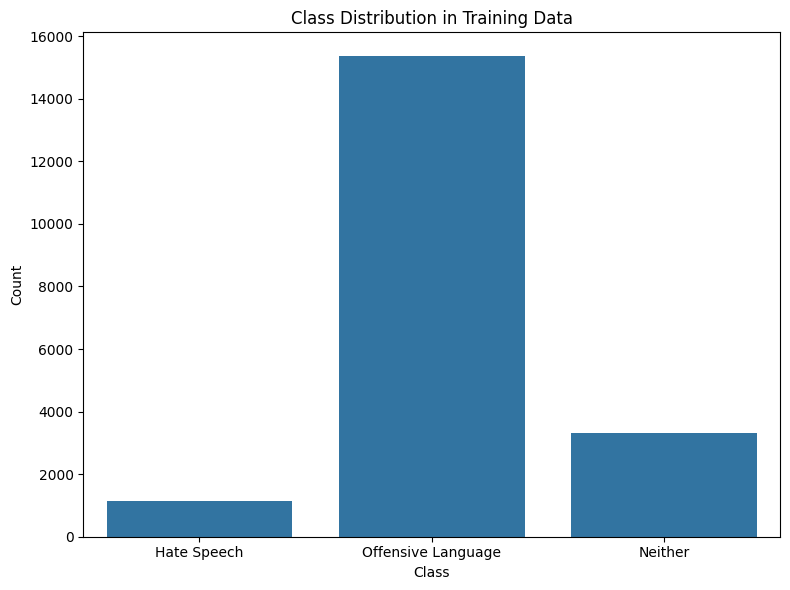

In [8]:
# Class distribution in training set
print("Class distribution in training set:")
print(train_df['class'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=train_df)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Hate Speech', 'Offensive Language', 'Neither'])
plt.tight_layout()
plt.show()

In [9]:
# Initialize stopwords
stop_words = set(stopwords.words('english'))
# Add some domain-specific stopwords
custom_stopwords = {'amp', 'rt', 'via'}
stop_words.update(custom_stopwords)

In [10]:
# Define slang/abbreviation dictionary
slang_dict = {
    'wtf': 'what the fuck',
    'stfu': 'shut the fuck up',
    'af': 'as fuck',
    'ngas': 'niggas',
    'lmao': 'laughing my ass off',
    'lmfao': 'laughing my fucking ass off',
    'idk': 'i do not know',
    'idc': 'i do not care',
    'omg': 'oh my god',
    'bs': 'bullshit',
    'mf': 'motherfucker',
    'pos': 'piece of shit',
    'fml': 'fuck my life',
    'tf': 'the fuck',
    'stg': 'swear to god',
    'tbh': 'to be honest',
    'imo': 'in my opinion',
    'btw': 'by the way',
    'fr': 'for real',
    'bc': 'because',
    'cuz': 'because',
    'u': 'you',
    'ur': 'your',
    'r': 'are',
    'n': 'and',
    'y': 'why',
    'gonna': 'going to',
    'wanna': 'want to',
    'gotta': 'got to',
    'rn': 'right now',
    'tryna': 'trying to',
    'ngl': 'not gonna lie',
    'ffs': 'for fucks sake',
    'sm': 'so much',
    'ppl': 'people',
    'irl': 'in real life',
    'thx': 'thanks',
    'tysm': 'thank you so much',
    'dm': 'direct message',
    'gtfo': 'get the fuck out',
    'kys': 'kill yourself',
    'smh': 'shaking my head',
    'kms': 'kill myself',
    'ong': 'on god',
    'fyi': 'for your information',
    'msm': 'mainstream media'
}

In [11]:
# Function to expand slang and abbreviations
def expand_slang(text):
    if not isinstance(text, str):
        return ""
    
    words = text.split()
    expanded = []
    for word in words:
        word_lower = word.lower()
        if word_lower in slang_dict:
            expanded.append(slang_dict[word_lower])
        else:
            expanded.append(word)
    return ' '.join(expanded)

In [12]:
# Simple tokenizer function
def simple_tokenize(text):
    """
    A simple tokenizer that splits text on whitespace and punctuation.
    """
    if not isinstance(text, str):
        return []
        
    # Replace punctuation with spaces
    for punct in string.punctuation:
        text = text.replace(punct, ' ')
    
    # Split on whitespace and filter out empty strings and stopwords
    tokens = [word for word in text.split() if word and len(word) > 1 and word not in stop_words]
    
    return tokens

In [13]:
# Text preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove emojis (Unicode ranges for most emoji)
        text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
        text = re.sub(r'[\u2600-\u26FF\u2700-\u27BF\u2B00-\u2BFF\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\U0001F900-\U0001F9FF]', '', text)
        
        # Remove URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        
        # Remove user mentions
        text = re.sub(r'@\w+', '', text)
        
        # Remove hashtags (keep the text, remove the # symbol)
        text = re.sub(r'#(\w+)', r'\1', text)
        
        # Remove RT prefix
        text = re.sub(r'^RT[\s]+', '', text)

        # Expand slang and abbreviations
        text = expand_slang(text)
        
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Tokenize with simple tokenizer
        tokens = simple_tokenize(text)
        
        # Remove stopwords
        filtered_tokens = [word for word in tokens if word not in stop_words]

        return filtered_tokens

In [14]:
# Demonstrate preprocessing on sample tweets
print("\nDemonstrating preprocessing on sample tweets:")
sample_tweets = [
    "indian ngas be looking like a piece of shit. all these street-shitters can do is rape biatches and make nasty food. wtf bro, the jew niggz aren't any better. and their diks be circumsized too. dang man"
]

for i, tweet in enumerate(sample_tweets):
    print(f"\nOriginal Tweet {i+1}: {tweet}")
    processed = preprocess_text(tweet)
    print(f"Processed: {processed}")


Demonstrating preprocessing on sample tweets:

Original Tweet 1: indian ngas be looking like a piece of shit. all these street-shitters can do is rape biatches and make nasty food. wtf bro, the jew niggz aren't any better. and their diks be circumsized too. dang man
Processed: ['indian', 'niggas', 'looking', 'like', 'piece', 'shit', 'streetshitters', 'rape', 'biatches', 'make', 'nasty', 'food', 'fuck', 'bro', 'jew', 'niggz', 'arent', 'better', 'diks', 'circumsized', 'dang', 'man']


In [15]:
# Add IDs to train and test sets if they don't already have them
if 'id' not in train_df.columns:
    train_df['id'] = range(len(train_df))
if 'id' not in test_df.columns:
    test_df['id'] = range(len(test_df))

In [16]:
# Apply preprocessing to train and test data
print("Preprocessing train tweets...")
train_df['preprocessed_tweet'] = train_df['tweet'].apply(preprocess_text)
print("Preprocessing test tweets...")
test_df['preprocessed_tweet'] = test_df['tweet'].apply(preprocess_text)

Preprocessing train tweets...
Preprocessing test tweets...


In [17]:
# Calculate sequence lengths to determine max_sequence_length
train_sequence_lengths = train_df['preprocessed_tweet'].apply(len)
print("Sequence length statistics:")
print(f"Min length: {train_sequence_lengths.min()}")
print(f"Max length: {train_sequence_lengths.max()}")
print(f"Mean length: {train_sequence_lengths.mean():.2f}")
print(f"Median length: {train_sequence_lengths.median()}")
print(f"95th percentile: {np.percentile(train_sequence_lengths, 95):.2f}")
print(f"99th percentile: {np.percentile(train_sequence_lengths, 99):.2f}")

Sequence length statistics:
Min length: 0
Max length: 24
Mean length: 7.55
Median length: 7.0
95th percentile: 14.00
99th percentile: 17.00


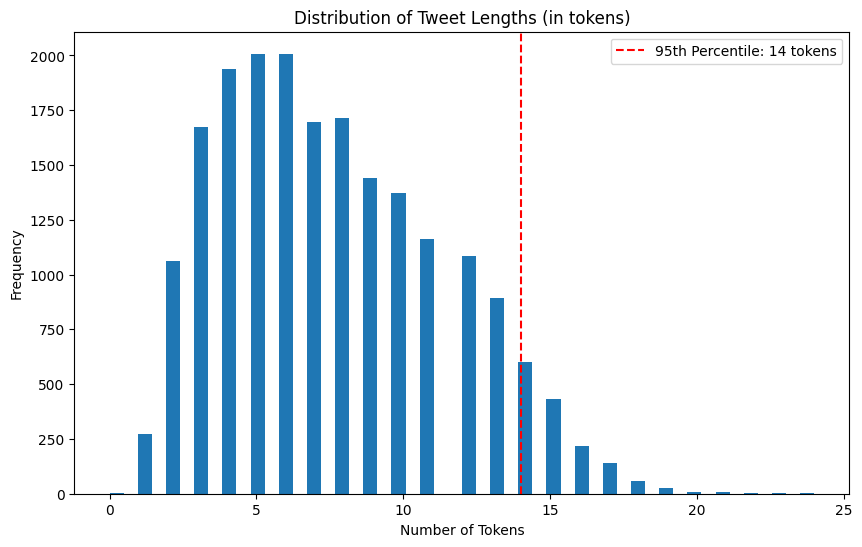

In [18]:
# Plot sequence length distribution
plt.figure(figsize=(10, 6))
plt.hist(train_sequence_lengths, bins=50)
plt.title('Distribution of Tweet Lengths (in tokens)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(x=np.percentile(train_sequence_lengths, 95), color='r', linestyle='--', 
            label=f'95th Percentile: {np.percentile(train_sequence_lengths, 95):.0f} tokens')
plt.legend()
plt.show()

In [19]:
# Choose max_sequence_length based on 95th percentile
max_sequence_length = int(np.percentile(train_sequence_lengths, 95))
print(f"Setting max_sequence_length to: {max_sequence_length}")

Setting max_sequence_length to: 14


In [21]:
# Load pre-trained Word2Vec embeddings
print("Loading pre-trained Word2Vec embeddings...")
word2vec_model = api.load('word2vec-google-news-300')
embedding_dim = 300  # Dimension of Word2Vec embeddings
print(f"Loaded pre-trained Word2Vec model with {len(word2vec_model.key_to_index)} words in vocabulary")

Loading pre-trained Word2Vec embeddings...
Loaded pre-trained Word2Vec model with 3000000 words in vocabulary


In [22]:
# Function to prepare sequence data
def prepare_sequence_data(texts, word2vec_model, max_sequence_length=100, embedding_dim=300):
    """
    Prepares sequence data for recurrent models (RNN, LSTM, GRU) and CNN.
    Instead of averaging embeddings, this creates padded sequences.
    
    Args:
        texts: List of preprocessed texts (lists of tokens)
        word2vec_model: Pre-trained word2vec model
        max_sequence_length: Maximum sequence length for padding/truncation
        embedding_dim: Dimension of word embeddings
        
    Returns:
        Numpy array of shape (n_samples, max_sequence_length, embedding_dim)
    """
    # Initialize the output array
    sequences = np.zeros((len(texts), max_sequence_length, embedding_dim))
    
    # For each text
    for i, text in enumerate(texts):
        if not isinstance(text, list):
            # Skip if not a list (e.g., if None)
            continue
            
        # For each word in the text (up to max_sequence_length)
        for j, word in enumerate(text[:max_sequence_length]):
            if word in word2vec_model:
                # Add the embedding to the sequence
                sequences[i, j] = word2vec_model[word]
    
    return sequences

In [23]:
# Prepare sequence data
print("Preparing sequence data for train set...")
X_train_sequences = prepare_sequence_data(
    train_df['preprocessed_tweet'].tolist(),
    word2vec_model,
    max_sequence_length=max_sequence_length,
    embedding_dim=embedding_dim
)
print(f"Shape of training sequence data: {X_train_sequences.shape}")

Preparing sequence data for train set...
Shape of training sequence data: (19826, 14, 300)


In [24]:
# Extract labels
y_train = train_df['class'].values
print("Shape of y_train (labels):", y_train.shape)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=3)

# Split the data into training and validation sets using sequence data
X_tr_seq, X_val_seq, y_tr, y_val = train_test_split(
    X_train_sequences, y_train_cat, test_size=0.2, random_state=42
)

Shape of y_train (labels): (19826,)


In [25]:
# Define model building functions with proper architectures
def build_lstm_model(embedding_dim, learning_rate=0.001, dropout_rate=0.5, units_1=256, units_2=128, max_sequence_length=100):
    """
    Build a true LSTM model that processes sequences
    
    Notes:
    - Requires sequence input, not averaged embeddings
    - Input shape should be (batch_size, max_sequence_length, embedding_dim)
    """
    model = Sequential()
    # Masking layer to handle variable sequence lengths
    model.add(Masking(mask_value=0.0, input_shape=(max_sequence_length, embedding_dim)))
    # First LSTM layer with return_sequences=True to feed into the next LSTM layer
    model.add(LSTM(units=units_1, return_sequences=True, dropout=dropout_rate))
    # Second LSTM layer 
    model.add(LSTM(units=units_2, dropout=dropout_rate))
    # Dense layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def build_gru_model(embedding_dim, learning_rate=0.001, dropout_rate=0.5, units_1=256, units_2=128, max_sequence_length=100):
    """
    Build a true GRU model that processes sequences
    
    Notes:
    - Requires sequence input, not averaged embeddings
    - Input shape should be (batch_size, max_sequence_length, embedding_dim)
    """
    model = Sequential()
    # Masking layer to handle variable sequence lengths
    model.add(Masking(mask_value=0.0, input_shape=(max_sequence_length, embedding_dim)))
    # First GRU layer with return_sequences=True to feed into the next GRU layer
    model.add(GRU(units=units_1, return_sequences=True, dropout=dropout_rate))
    # Second GRU layer
    model.add(GRU(units=units_2, dropout=dropout_rate))
    # Dense layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def build_cnn_model(embedding_dim, learning_rate=0.001, dropout_rate=0.5, max_sequence_length=100):
    """
    Build a true CNN model for text classification
    
    Notes:
    - Uses 1D convolutions to capture n-gram patterns
    - Requires sequence input, not averaged embeddings
    - Input shape should be (batch_size, max_sequence_length, embedding_dim)
    """
    model = Sequential()
    # Input layer
    model.add(Masking(mask_value=0.0, input_shape=(max_sequence_length, embedding_dim)))
    
    # Parallel convolutional layers with different kernel sizes to capture different n-gram patterns
    # Create three separate convolutional branches
    
    # Branch 1: 3-gram patterns
    model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # Add a second convolutional layer
    model.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # Flatten the output
    model.add(Flatten())
    
    # Dense layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def build_rnn_model(embedding_dim, learning_rate=0.001, dropout_rate=0.5, units_1=256, units_2=128, max_sequence_length=100):
    """
    Build a true RNN model that processes sequences
    
    Notes:
    - Uses SimpleRNN layers
    - Requires sequence input, not averaged embeddings
    - Input shape should be (batch_size, max_sequence_length, embedding_dim)
    """
    model = Sequential()
    # Masking layer to handle variable sequence lengths
    model.add(Masking(mask_value=0.0, input_shape=(max_sequence_length, embedding_dim)))
    # First SimpleRNN layer with return_sequences=True to feed into the next RNN layer
    model.add(SimpleRNN(units=units_1, return_sequences=True, dropout=dropout_rate))
    # Second SimpleRNN layer
    model.add(SimpleRNN(units=units_2, dropout=dropout_rate))
    # Dense layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [26]:
# Function to train and evaluate models
def train_and_evaluate_model(model, X_train, y_train, model_name):
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'{model_name}.h5', save_best_only=True, save_weights_only=False)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )
    
    # Create a validation set from the training data to evaluate the model
    _, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    # Evaluate the model
    y_pred_proba = model.predict(X_val)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_val, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Save model performance
    model_performance = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'history': history
    }
    
    return model_performance

In [27]:
# Initialize a list to store model performances
model_performances = []

In [28]:
# Build and train LSTM model
print("Building and training LSTM model...")
lstm_model = build_lstm_model(
    embedding_dim,
    learning_rate=0.001,
    dropout_rate=0.5,
    units_1=256,
    units_2=128,
    max_sequence_length=max_sequence_length
)
lstm_model.summary()
lstm_performance = train_and_evaluate_model(lstm_model, X_train_sequences, y_train_cat, 'lstm_model')
model_performances.append(lstm_performance)

# Build and train GRU model
print("\nBuilding and training GRU model...")
gru_model = build_gru_model(
    embedding_dim,
    learning_rate=0.001,
    dropout_rate=0.5,
    units_1=256,
    units_2=128,
    max_sequence_length=max_sequence_length
)
gru_model.summary()
gru_performance = train_and_evaluate_model(gru_model, X_train_sequences, y_train_cat, 'gru_model')
model_performances.append(gru_performance)

# Build and train CNN model
print("\nBuilding and training CNN model...")
cnn_model = build_cnn_model(
    embedding_dim,
    learning_rate=0.001,
    dropout_rate=0.5,
    max_sequence_length=max_sequence_length
)
cnn_model.summary()
cnn_performance = train_and_evaluate_model(cnn_model, X_train_sequences, y_train_cat, 'cnn_model')
model_performances.append(cnn_performance)

# Build and train RNN model
print("\nBuilding and training RNN model...")
rnn_model = build_rnn_model(
    embedding_dim,
    learning_rate=0.001,
    dropout_rate=0.5,
    units_1=256,
    units_2=128,
    max_sequence_length=max_sequence_length
)
rnn_model.summary()
rnn_performance = train_and_evaluate_model(rnn_model, X_train_sequences, y_train_cat, 'rnn_model')
model_performances.append(rnn_performance)

Building and training LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 14, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 14, 256)             │         570,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 775,939 (2.96 MB)

 Trainable params: 775,939 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8024 - loss: 0.5784 

248/248 ━━━━━━━━━━━━━━━━━━━━ 104s 127ms/step - accuracy: 0.8025 - loss: 0.5780 - val_accuracy: 0.8870 - val_loss: 0.3207
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8616 - loss: 0.3713 

248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.8616 - loss: 0.3713 - val_accuracy: 0.8923 - val_loss: 0.3078
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8673 - loss: 0.3531 

248/248 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.8673 - loss: 0.3531 - val_accuracy: 0.8959 - val_loss: 0.3055
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8723 - loss: 0.3332 

248/248 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.8723 - loss: 0.3332 - val_accuracy: 0.8959 - val_loss: 0.2895
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8768 - loss: 0.3256 

248/248 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8768 - loss: 0.3256 - val_accuracy: 0.8961 - val_loss: 0.2888
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8803 - loss: 0.3163 

248/248 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.8803 - loss: 0.3163 - val_accuracy: 0.9022 - val_loss: 0.2885
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8840 - loss: 0.3092 

248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.8840 - loss: 0.3092 - val_accuracy: 0.9039 - val_loss: 0.2795
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8866 - loss: 0.2942 

248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.8866 - loss: 0.2942 - val_accuracy: 0.9009 - val_loss: 0.2762
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8872 - loss: 0.2946 

248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.8872 - loss: 0.2947 - val_accuracy: 0.9044 - val_loss: 0.2749
Epoch 10/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.8902 - loss: 0.2854 - val_accuracy: 0.8974 - val_loss: 0.2789
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step

lstm_model Evaluation:
Accuracy: 0.9042
Precision: 0.8930
Recall: 0.9042
F1 Score: 0.8948

Building and training GRU model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 14, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 14, 256)             │         428,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 585,219 (2.23 MB)

 Trainable params: 585,219 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8015 - loss: 0.5440 

248/248 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.8016 - loss: 0.5436 - val_accuracy: 0.8906 - val_loss: 0.3118
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8634 - loss: 0.3660 

248/248 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.8635 - loss: 0.3660 - val_accuracy: 0.8974 - val_loss: 0.3063
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8702 - loss: 0.3431 

248/248 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8702 - loss: 0.3431 - val_accuracy: 0.9024 - val_loss: 0.3023
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8718 - loss: 0.3391 

248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.8718 - loss: 0.3391 - val_accuracy: 0.9017 - val_loss: 0.2889
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8783 - loss: 0.3211 

248/248 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.8783 - loss: 0.3211 - val_accuracy: 0.9017 - val_loss: 0.2858
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8830 - loss: 0.3096 

248/248 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.8829 - loss: 0.3097 - val_accuracy: 0.9072 - val_loss: 0.2796
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8871 - loss: 0.3065 

248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.8871 - loss: 0.3065 - val_accuracy: 0.9037 - val_loss: 0.2741
Epoch 8/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.8858 - loss: 0.3024 - val_accuracy: 0.9027 - val_loss: 0.2755
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step - accuracy: 0.8881 - loss: 0.2909 - val_accuracy: 0.9004 - val_loss: 0.2775
Epoch 10/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.8903 - loss: 0.2959 - val_accuracy: 0.8969 - val_loss: 0.2829
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

gru_model Evaluation:
Accuracy: 0.9029
Precision: 0.8900
Recall: 0.9029
F1 Score: 0.8898

Building and training CNN model...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)                  │ (None, 14, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 12, 128)             │         115,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 4, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 2, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,339 (837.26 KB)

 Trainable params: 214,339 (837.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8111 - loss: 0.5344

248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8113 - loss: 0.5340 - val_accuracy: 0.8875 - val_loss: 0.3241
Epoch 2/10
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8843 - loss: 0.3274

248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8844 - loss: 0.3273 - val_accuracy: 0.8916 - val_loss: 0.3101
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9038 - loss: 0.2686 - val_accuracy: 0.8891 - val_loss: 0.3390
Epoch 4/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9135 - loss: 0.2277 - val_accuracy: 0.8822 - val_loss: 0.3769
Epoch 5/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9252 - loss: 0.1888 - val_accuracy: 0.8651 - val_loss: 0.3786
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step   

cnn_model Evaluation:
Accuracy: 0.9070
Precision: 0.8551
Recall: 0.9070
F1 Score: 0.8802

Building and training RNN model...


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)                  │ (None, 14, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 14, 256)             │         142,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 128)                 │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 200,323 (782.51 KB)

 Trainable params: 200,323 (782.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7448 - loss: 0.6796

248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.7453 - loss: 0.6787 - val_accuracy: 0.8737 - val_loss: 0.3693
Epoch 2/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8364 - loss: 0.4637

248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8364 - loss: 0.4637 - val_accuracy: 0.8815 - val_loss: 0.3590
Epoch 3/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8432 - loss: 0.4432 - val_accuracy: 0.8838 - val_loss: 0.3615
Epoch 4/10
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8447 - loss: 0.4338

248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8448 - loss: 0.4337 - val_accuracy: 0.8797 - val_loss: 0.3468
Epoch 5/10
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8441 - loss: 0.4239

248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8442 - loss: 0.4238 - val_accuracy: 0.8802 - val_loss: 0.3335
Epoch 6/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8530 - loss: 0.4053 - val_accuracy: 0.8787 - val_loss: 0.3491
Epoch 7/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8644 - loss: 0.3903 

248/248 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8644 - loss: 0.3903 - val_accuracy: 0.8838 - val_loss: 0.3190
Epoch 8/10
247/248 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8618 - loss: 0.3835

248/248 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8617 - loss: 0.3835 - val_accuracy: 0.8873 - val_loss: 0.3116
Epoch 9/10
248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8630 - loss: 0.3730 - val_accuracy: 0.8886 - val_loss: 0.3232
Epoch 10/10
246/248 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8662 - loss: 0.3635

248/248 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8662 - loss: 0.3635 - val_accuracy: 0.8883 - val_loss: 0.3094
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step  

rnn_model Evaluation:
Accuracy: 0.8865
Precision: 0.8646
Recall: 0.8865
F1 Score: 0.8611


In [29]:
# Create a dataframe with model performances
performance_df = pd.DataFrame([
    {
        'Model': perf['model_name'],
        'Accuracy': perf['accuracy'],
        'Precision': perf['precision'],
        'Recall': perf['recall'],
        'F1 Score': perf['f1']
    }
    for perf in model_performances
])

In [30]:
# Display model performances
performance_df.sort_values(by='F1 Score', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
0,lstm_model,0.904186,0.893023,0.904186,0.894807
1,gru_model,0.902925,0.890013,0.902925,0.889783
2,cnn_model,0.906959,0.855103,0.906959,0.880150
3,rnn_model,0.886536,0.864574,0.886536,0.861056


In [31]:
# Find the best model based on F1 score
best_model_info = performance_df.loc[performance_df['F1 Score'].idxmax()]
best_model_name = best_model_info['Model']
print(f"\nBest Model: {best_model_name}")
print(f"Best Model F1 Score: {best_model_info['F1 Score']:.4f}")


Best Model: lstm_model
Best Model F1 Score: 0.8948


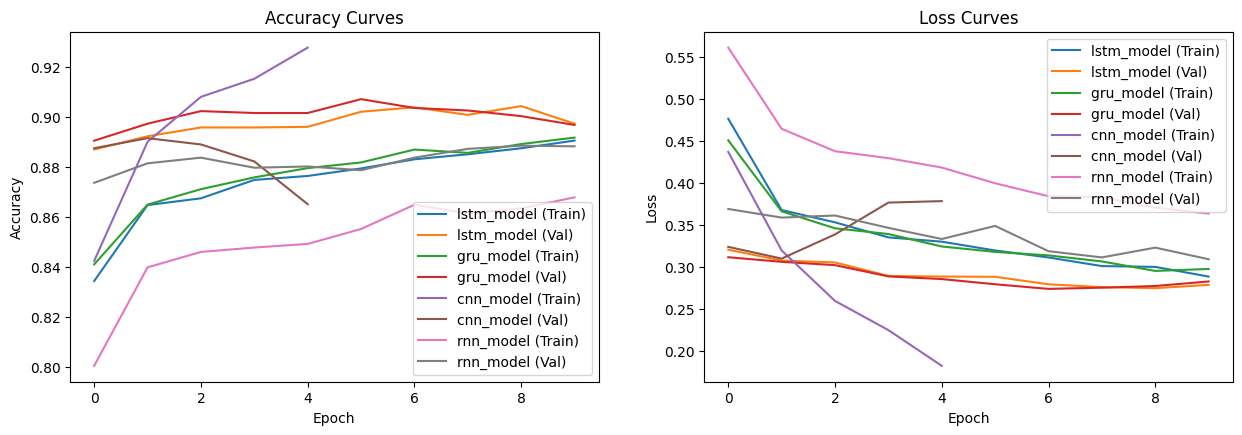

In [32]:
# Set up the figure for plotting
plt.figure(figsize=(15, 10))

# Plot accuracy curves for all models
plt.subplot(2, 2, 1)
for perf in model_performances:
    plt.plot(perf['history'].history['accuracy'], label=f"{perf['model_name']} (Train)")
    plt.plot(perf['history'].history['val_accuracy'], label=f"{perf['model_name']} (Val)")
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curves for all models
plt.subplot(2, 2, 2)
for perf in model_performances:
    plt.plot(perf['history'].history['loss'], label=f"{perf['model_name']} (Train)")
    plt.plot(perf['history'].history['val_loss'], label=f"{perf['model_name']} (Val)")
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

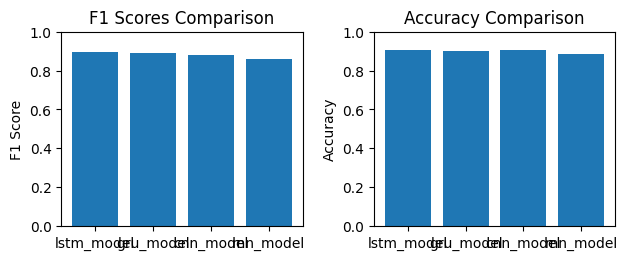

In [33]:
# Plot F1 scores
plt.subplot(2, 2, 3)
models = [perf['model_name'] for perf in model_performances]
f1_scores = [perf['f1'] for perf in model_performances]
plt.bar(models, f1_scores)
plt.title('F1 Scores Comparison')
plt.ylabel('F1 Score')
plt.ylim(0, 1)

# Plot accuracy scores
plt.subplot(2, 2, 4)
accuracy_scores = [perf['accuracy'] for perf in model_performances]
plt.bar(models, accuracy_scores)
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

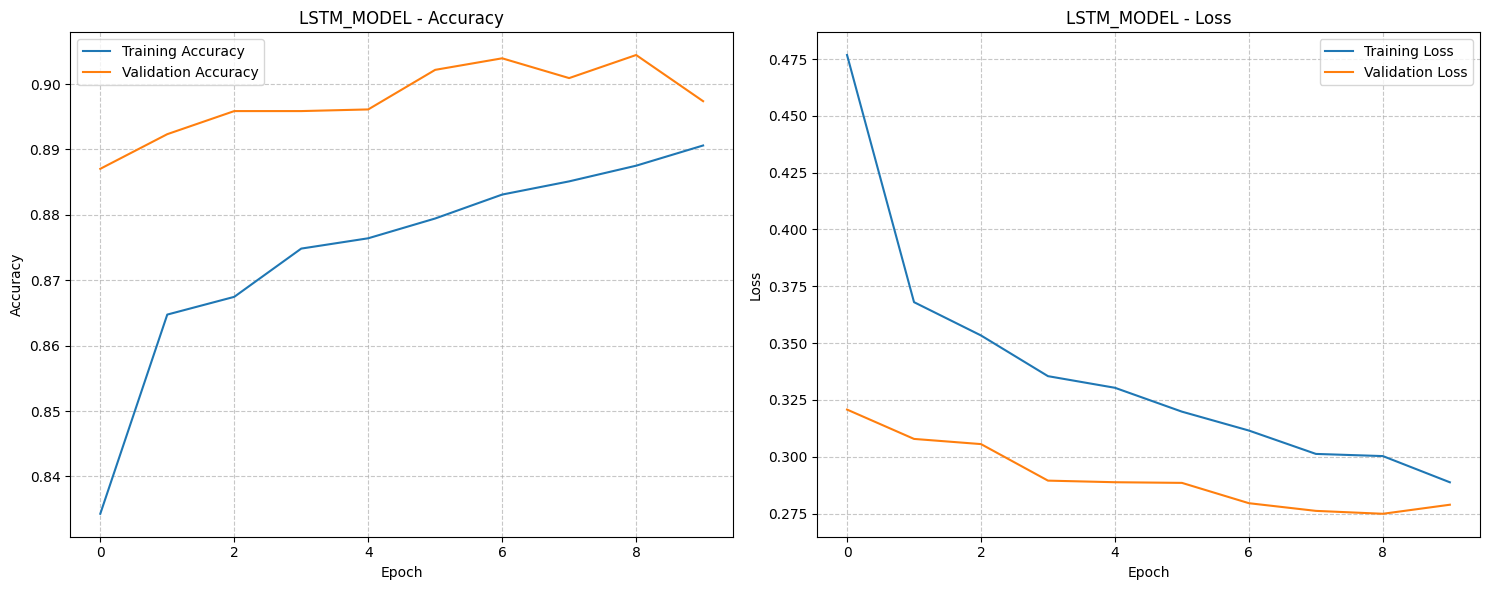

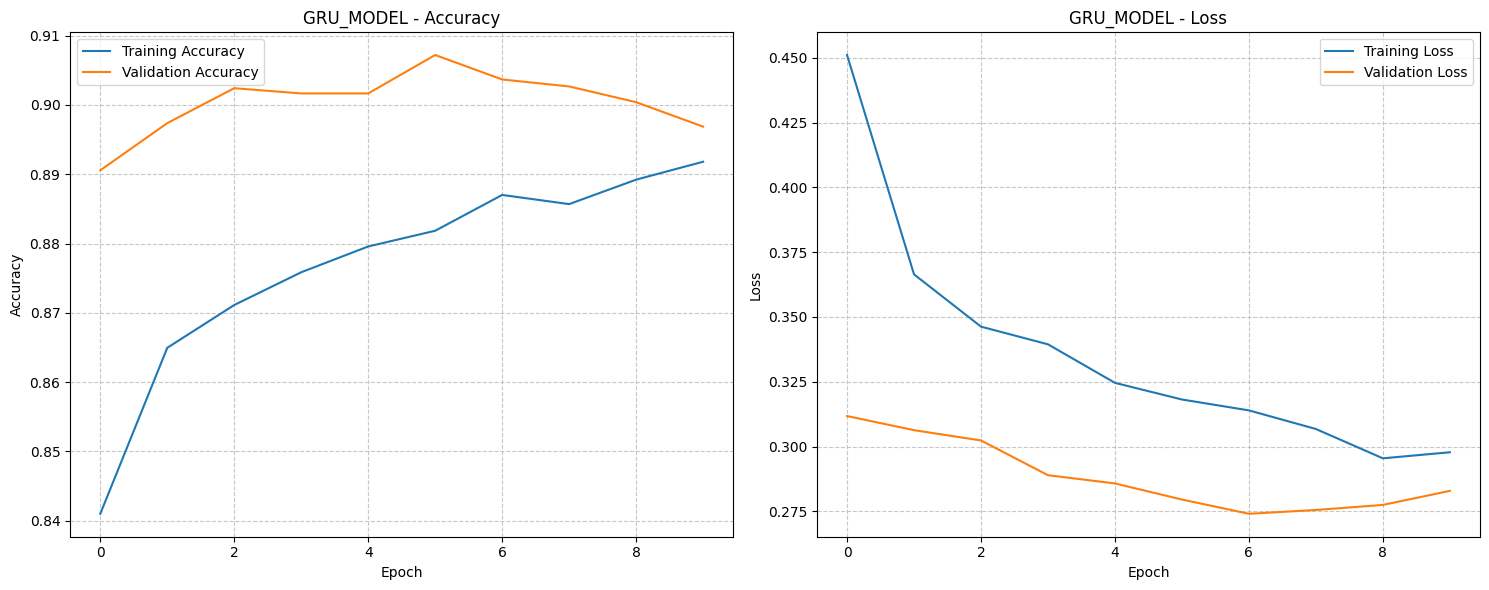

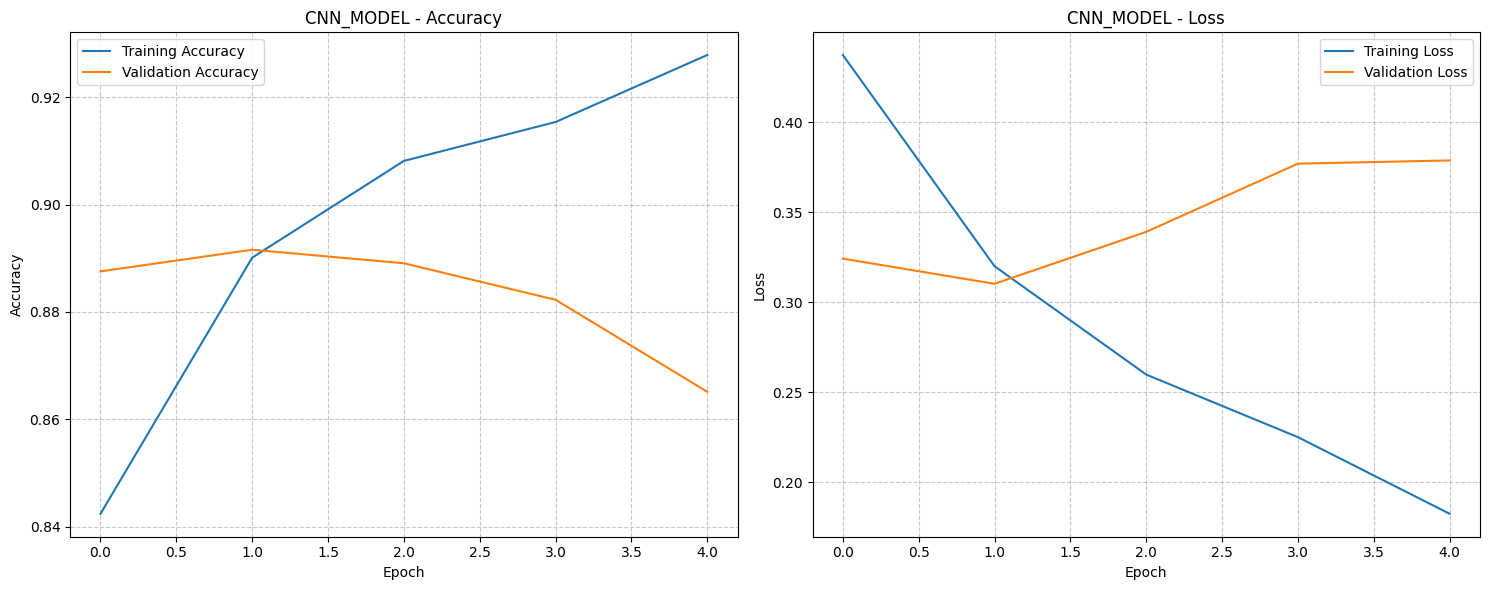

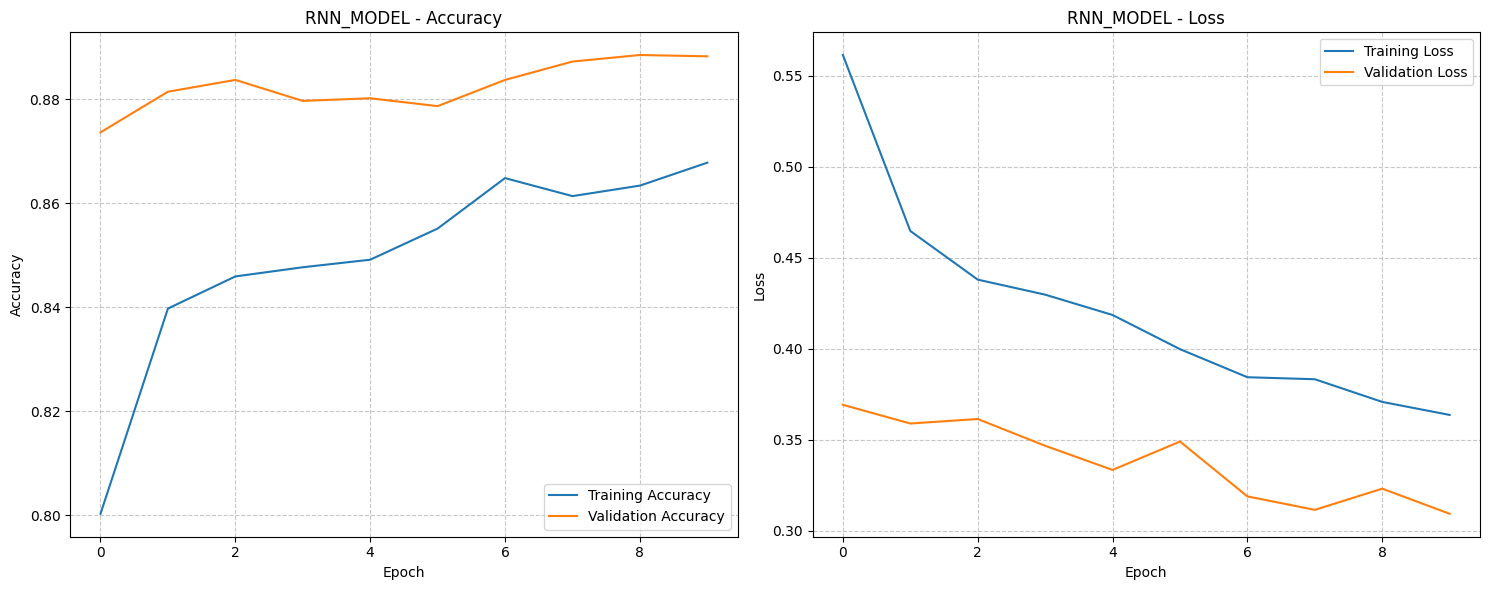

In [40]:
# Create separate graphs for each model
model_names = ['lstm_model', 'gru_model', 'cnn_model', 'rnn_model']

for model_name in model_names:
    # Find the performance data for this model
    model_perf = next((perf for perf in model_performances if perf['model_name'] == model_name), None)
    
    if model_perf:
        # Set up a figure with 2 subplots (accuracy and loss)
        plt.figure(figsize=(15, 6))
        
        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(model_perf['history'].history['accuracy'], label='Training Accuracy')
        plt.plot(model_perf['history'].history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name.upper()} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(model_perf['history'].history['loss'], label='Training Loss')
        plt.plot(model_perf['history'].history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name.upper()} - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(f'{model_name}_performance.png', dpi=300, bbox_inches='tight')
        plt.show()

In [36]:
# Prepare test data for prediction with the best model
print("Preparing sequence data for test set...")
X_test_sequences = prepare_sequence_data(
    test_df['preprocessed_tweet'].tolist(),
    word2vec_model,
    max_sequence_length=max_sequence_length,
    embedding_dim=embedding_dim
)
print(f"Shape of test sequence data: {X_test_sequences.shape}")

Preparing sequence data for test set...
Shape of test sequence data: (4957, 14, 300)


In [37]:
# Get predictions using the best model
if best_model_name == 'lstm_model':
    best_model = lstm_model
elif best_model_name == 'gru_model':
    best_model = gru_model
elif best_model_name == 'cnn_model':
    best_model = cnn_model
else:  # rnn_model
    best_model = rnn_model

In [38]:
# Generate predictions
test_predictions_proba = best_model.predict(X_test_sequences)
test_predictions = np.argmax(test_predictions_proba, axis=1)

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


In [39]:
# Create submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'predicted_class': test_predictions
})
submission_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved to 'model_predictions.csv'")

Predictions saved to 'model_predictions.csv'
